# Dummy data
**Goal**: Create dummy data to test the estimator on

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklego.loess import LoessSmoother, random_x, generate_noisy_sine_data, plot_windows
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

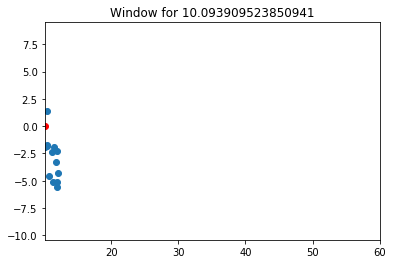

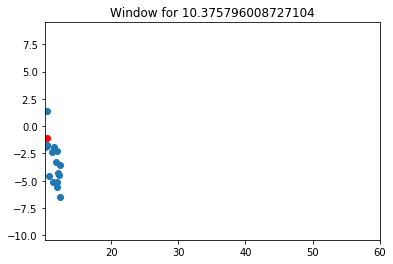

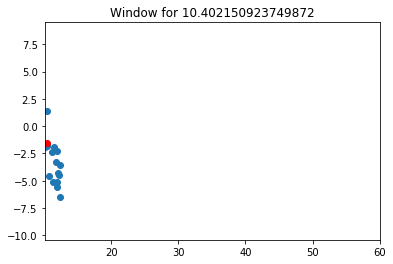

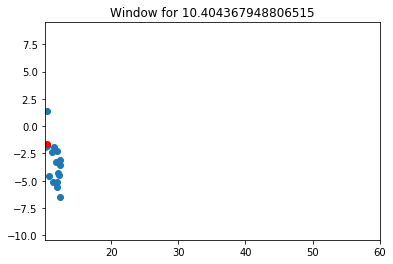

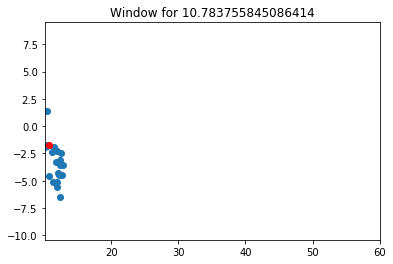

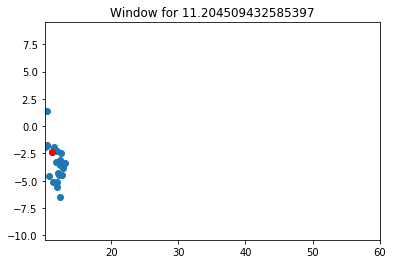

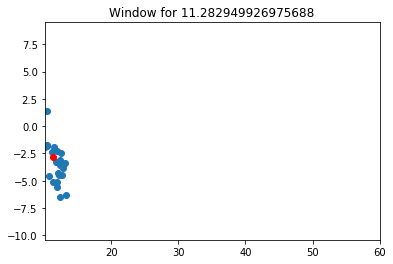

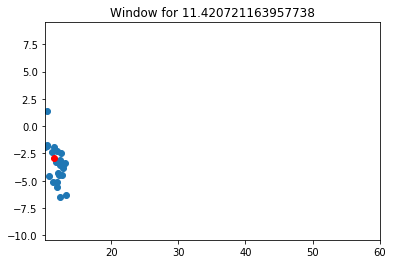

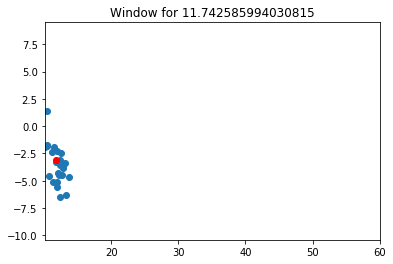

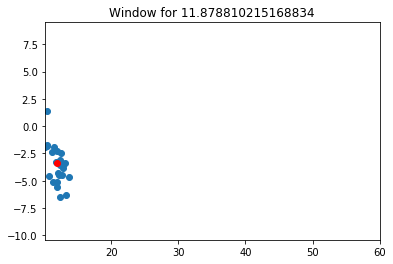

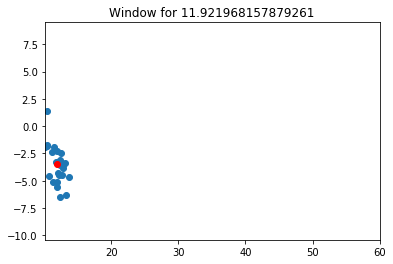

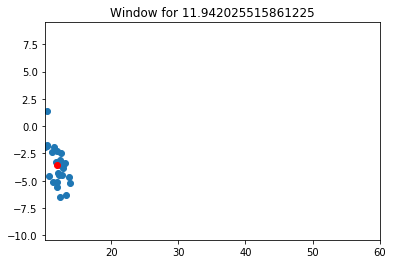

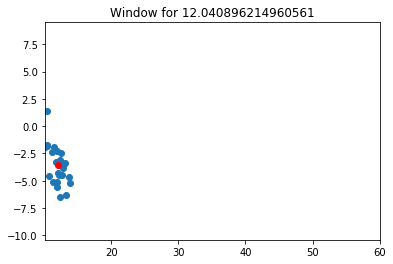

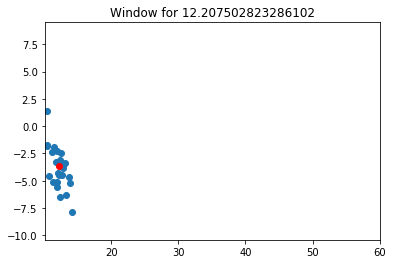

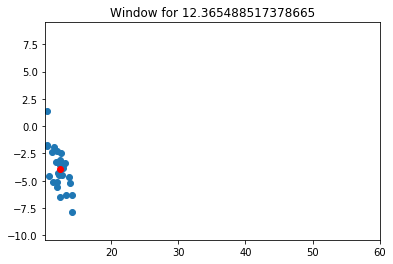

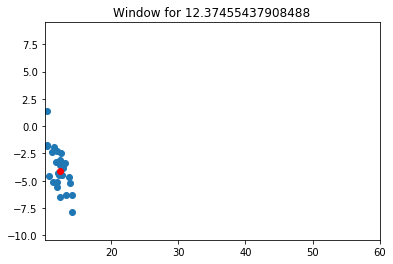

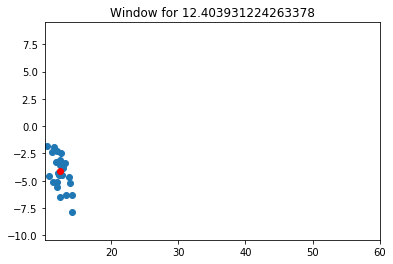

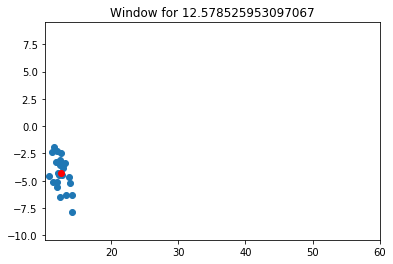

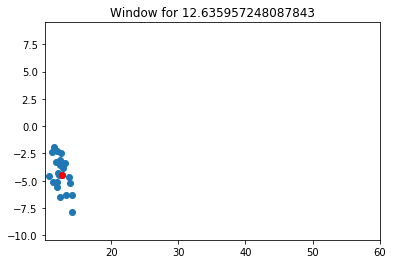

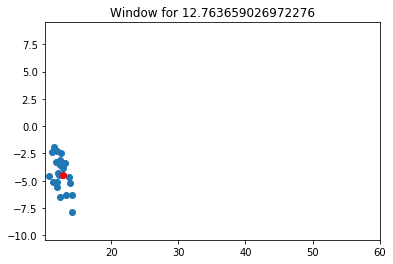

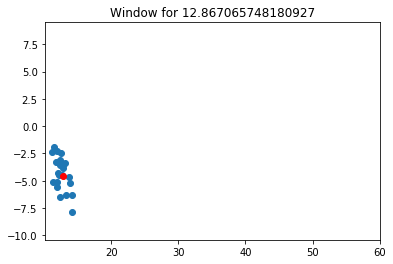

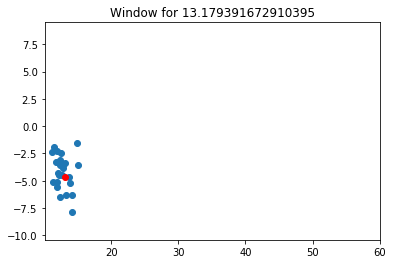

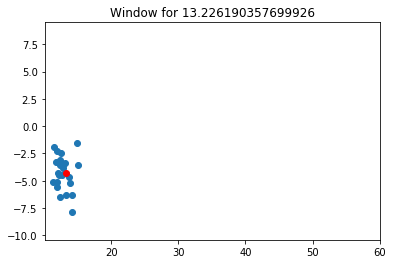

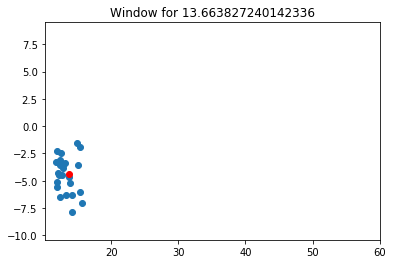

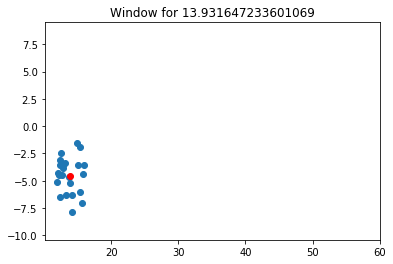

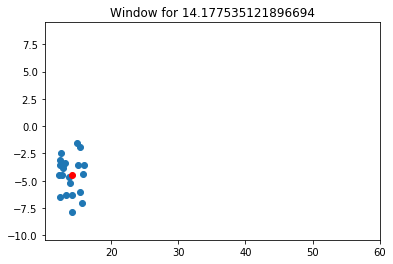

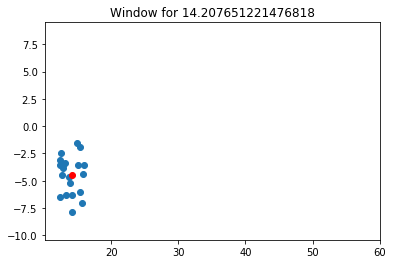

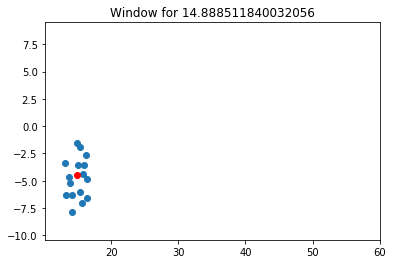

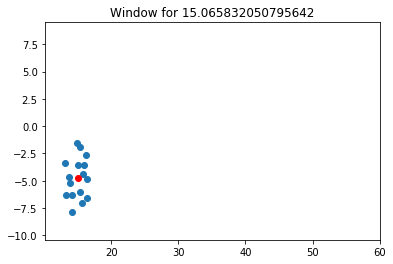

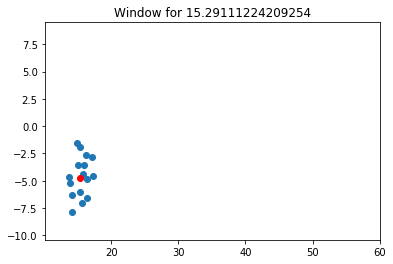

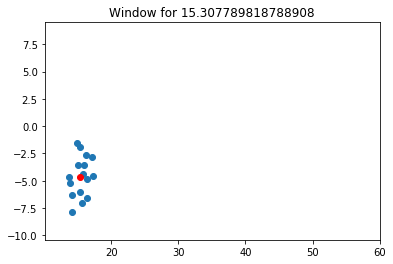

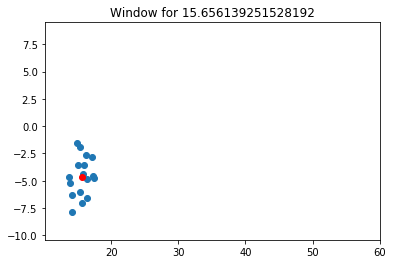

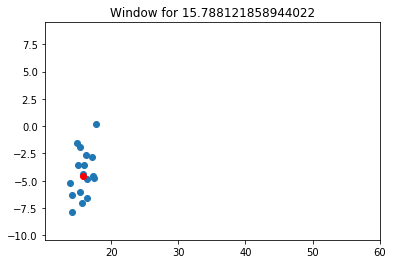

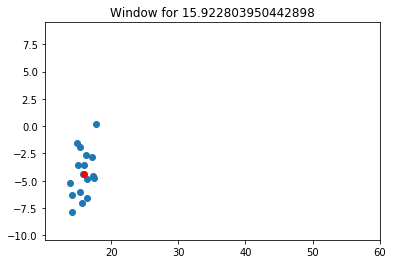

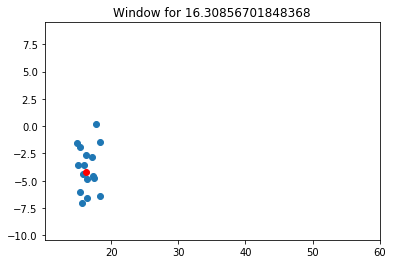

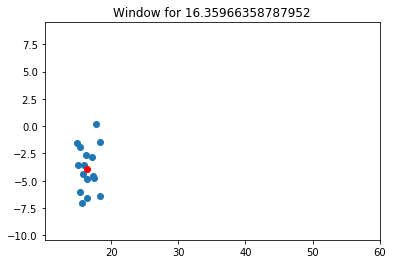

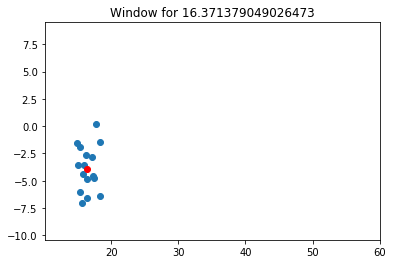

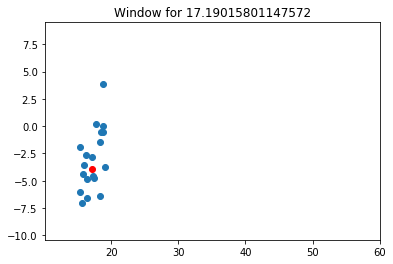

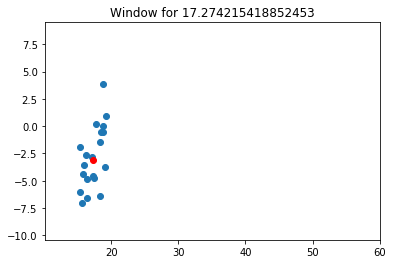

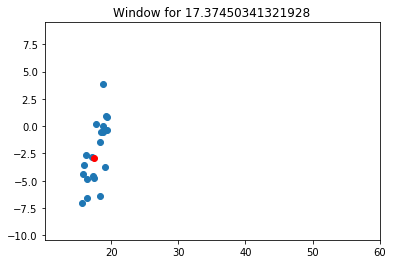

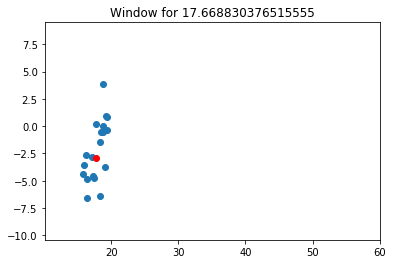

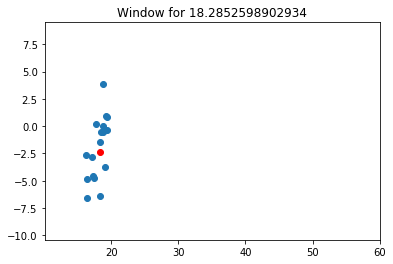

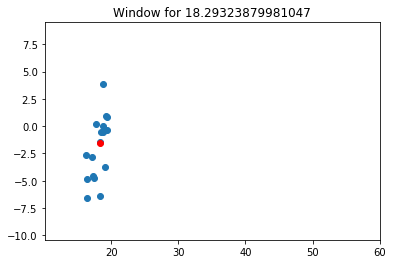

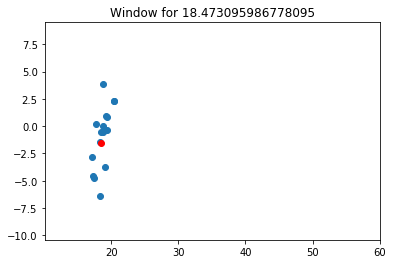

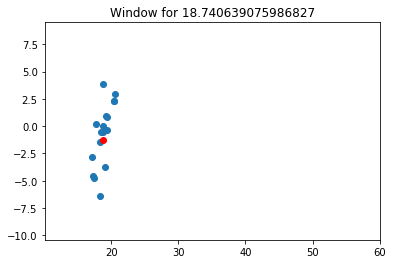

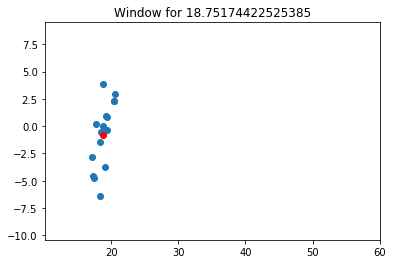

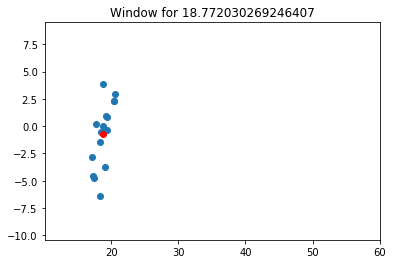

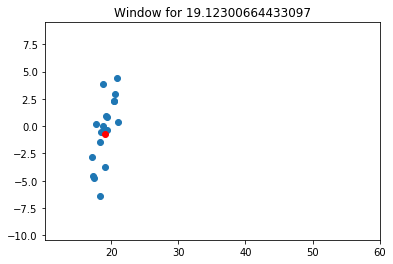

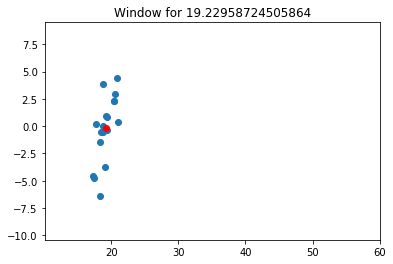

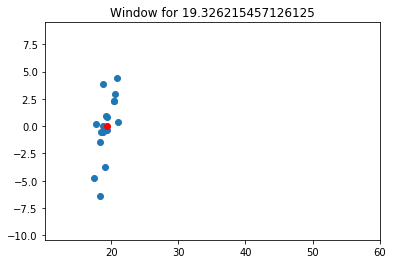

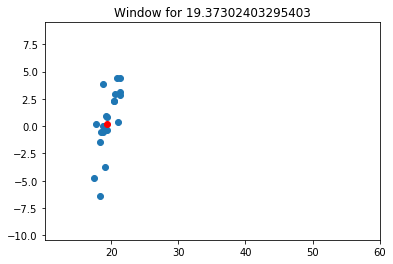

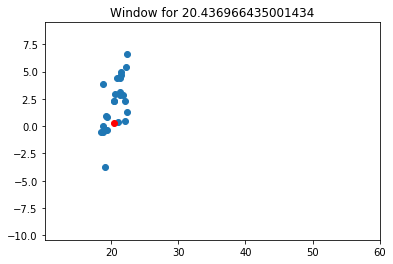

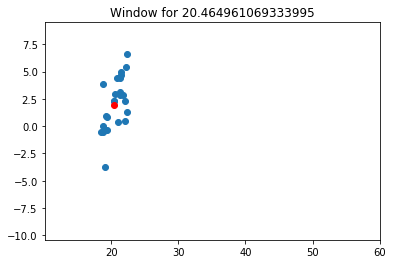

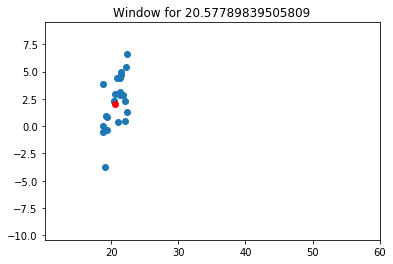

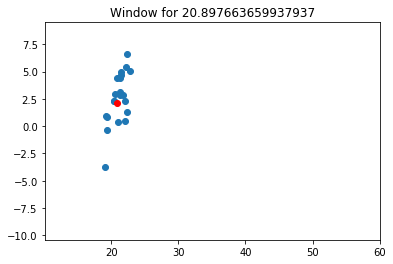

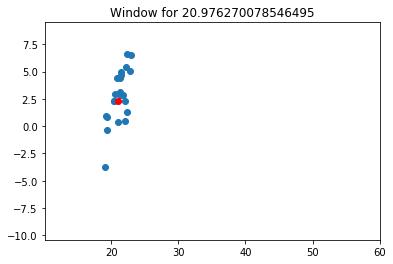

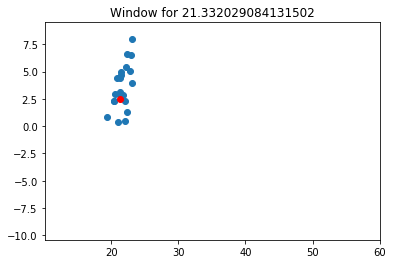

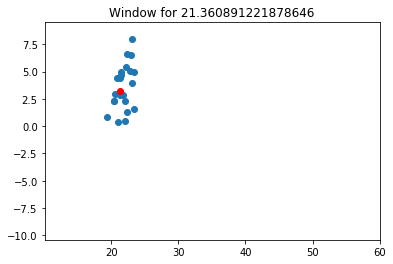

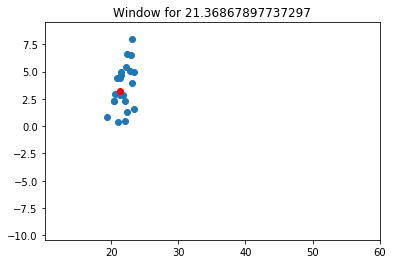

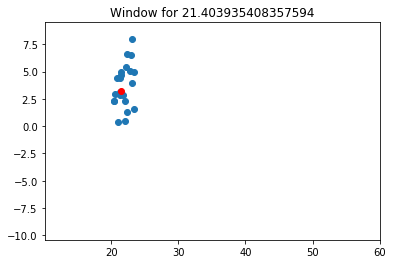

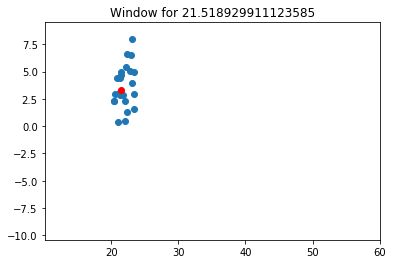

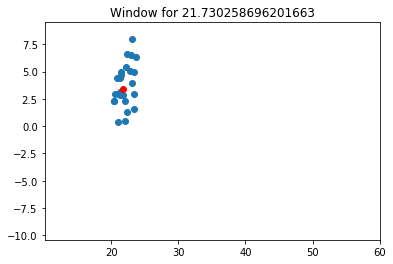

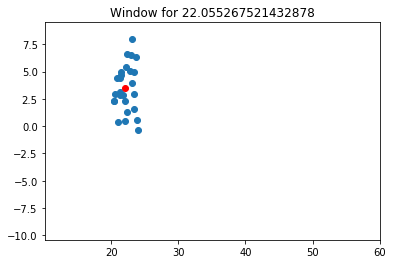

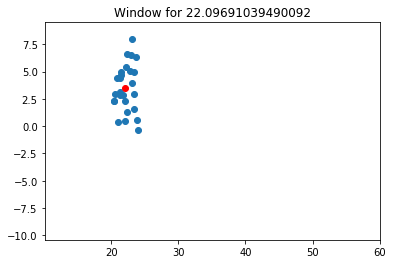

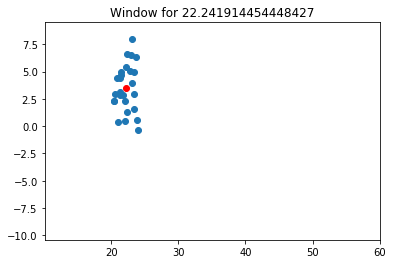

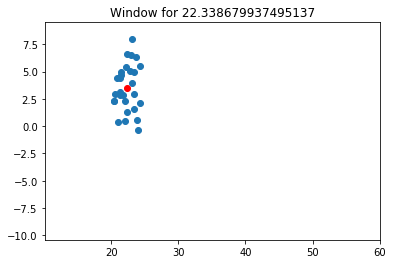

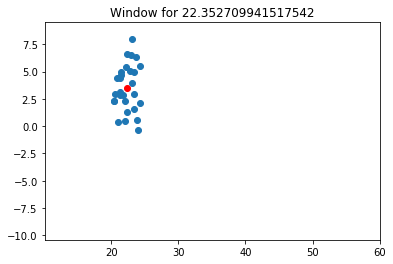

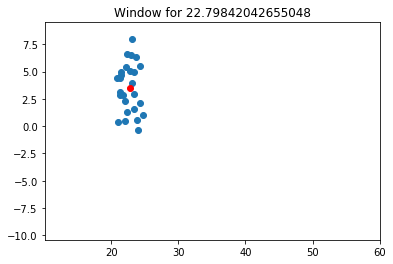

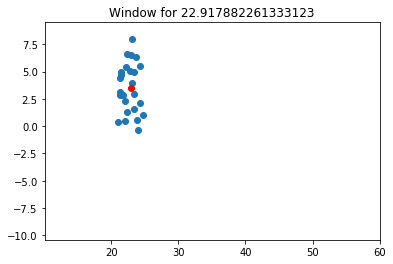

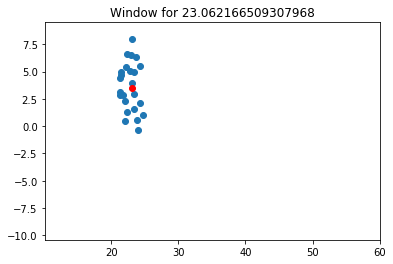

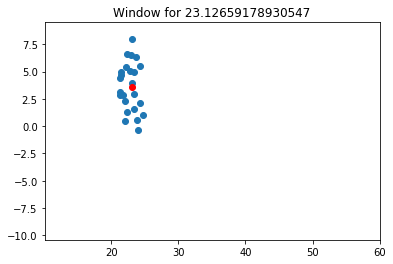

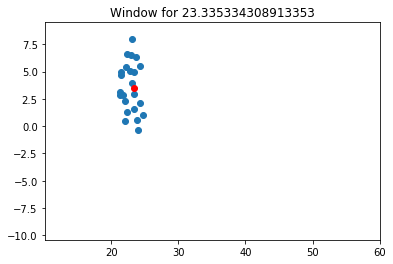

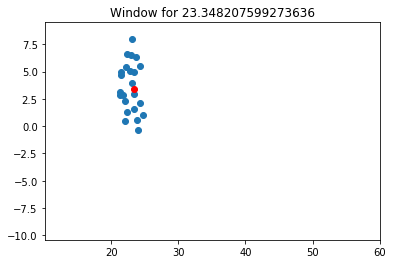

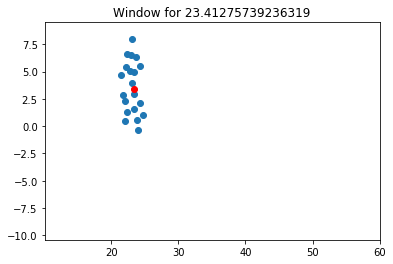

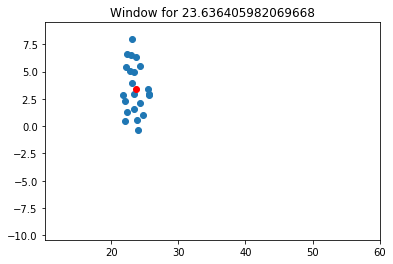

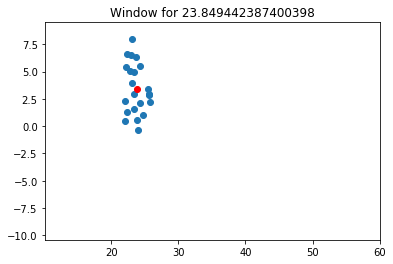

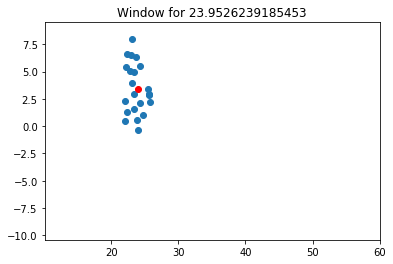

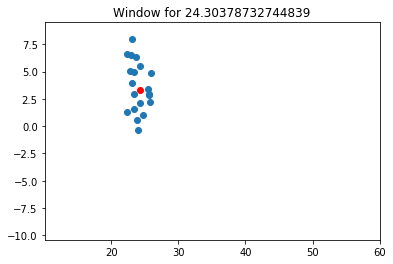

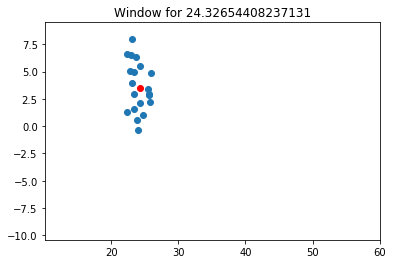

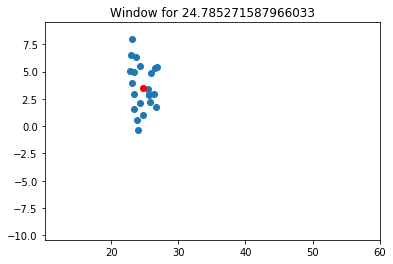

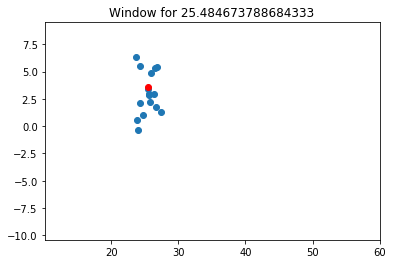

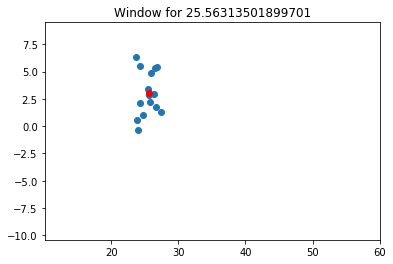

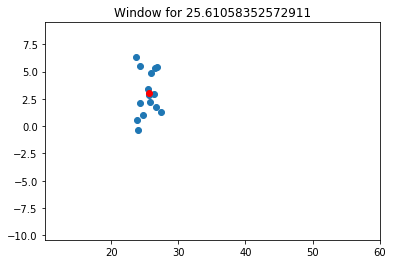

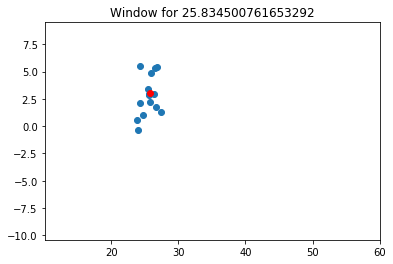

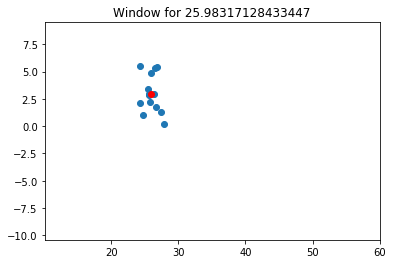

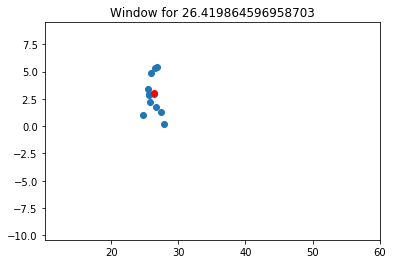

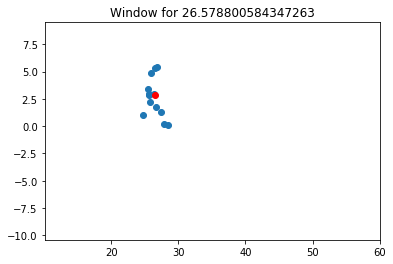

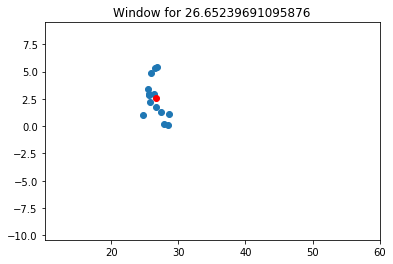

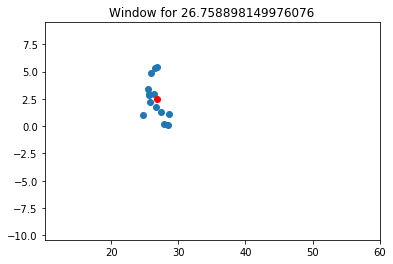

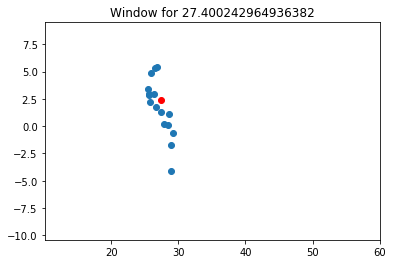

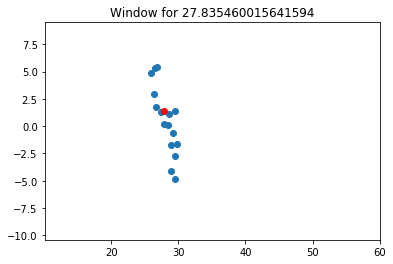

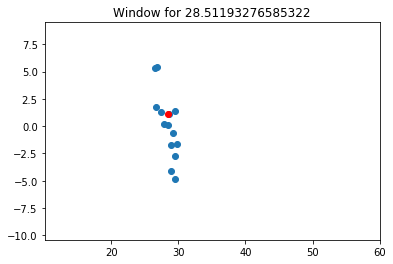

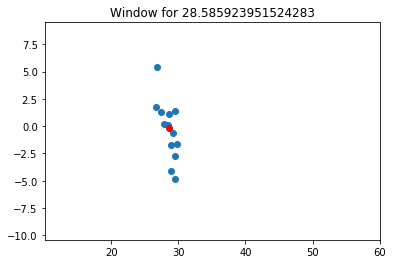

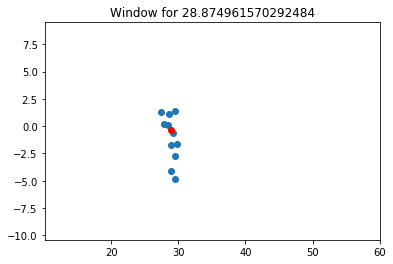

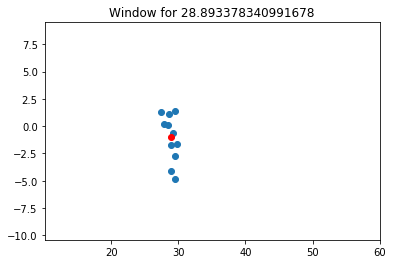

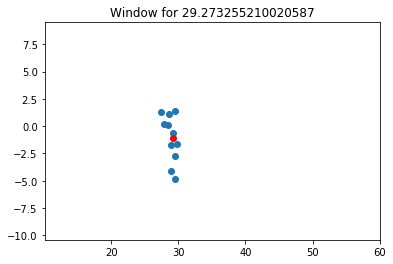

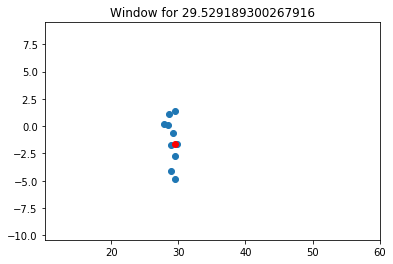

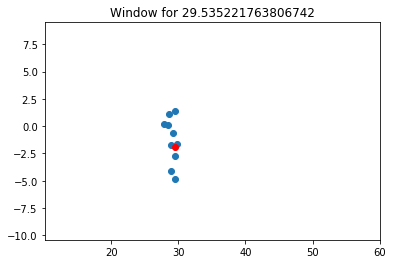

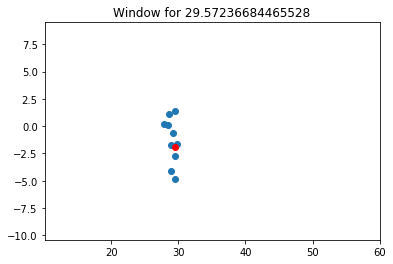

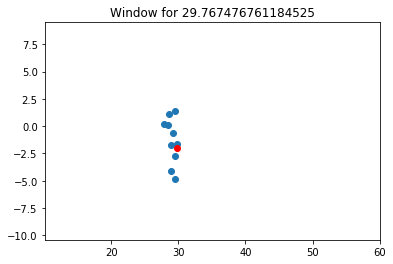

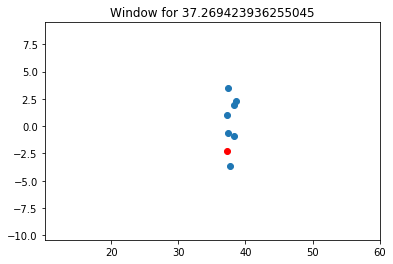

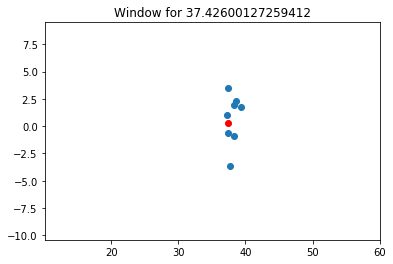

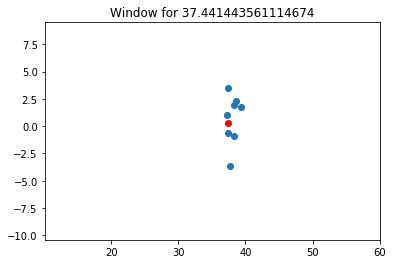

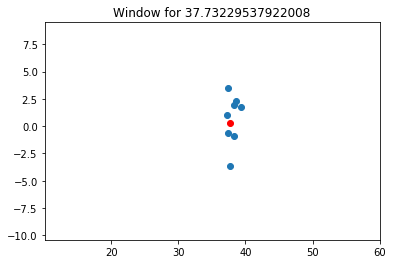

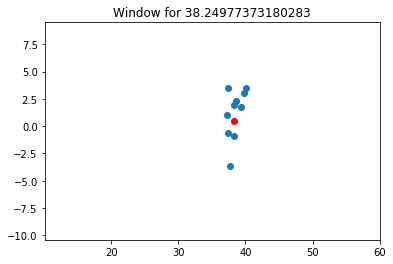

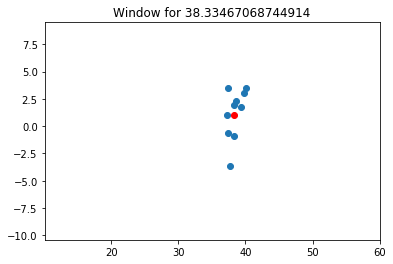

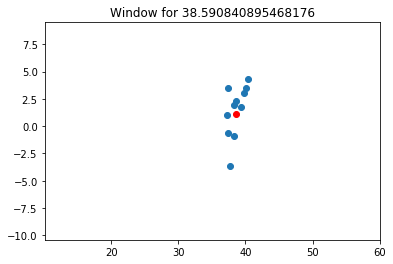

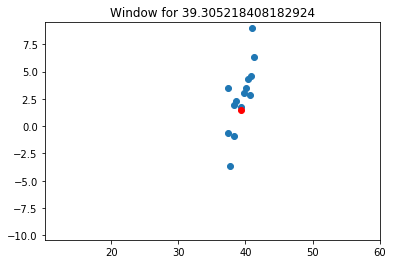

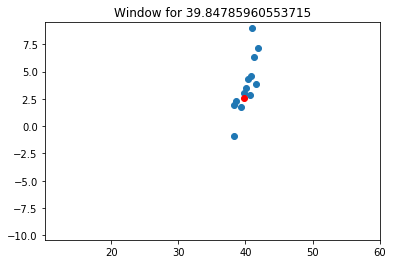

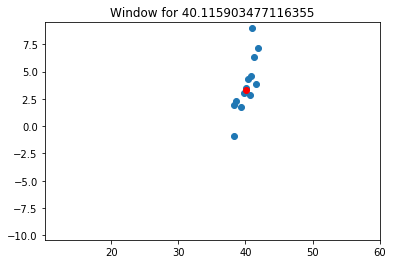

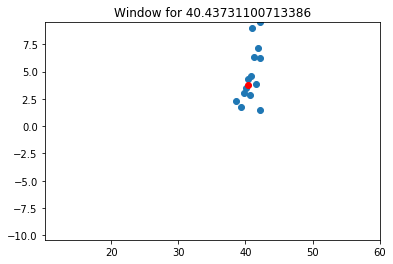

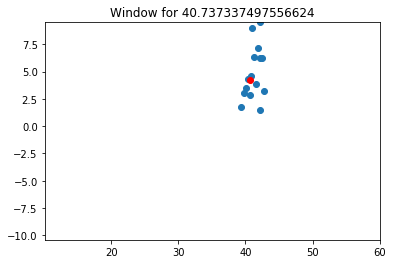

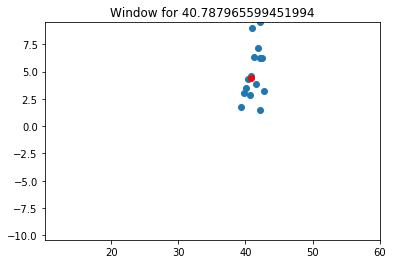

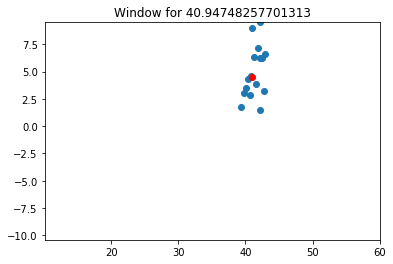

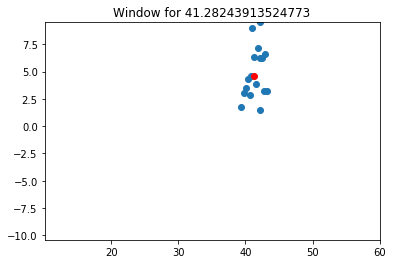

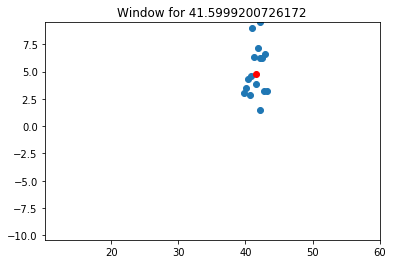

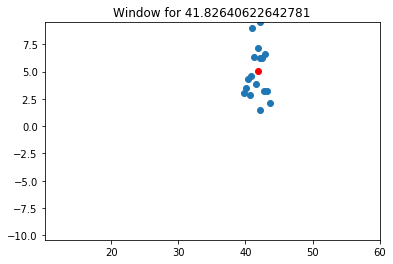

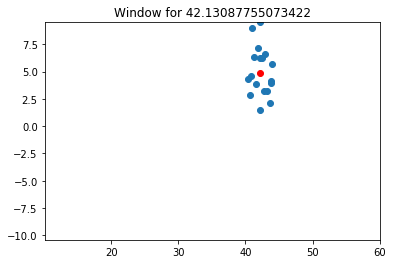

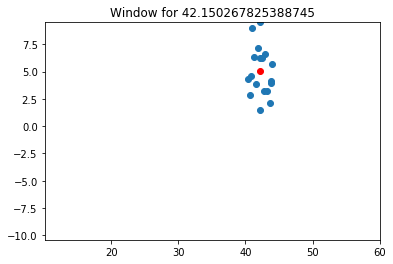

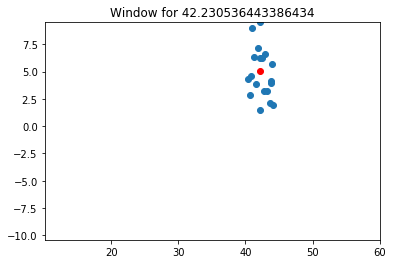

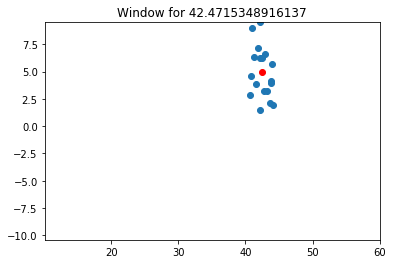

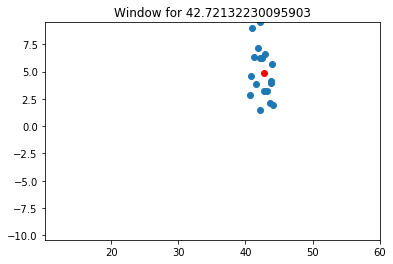

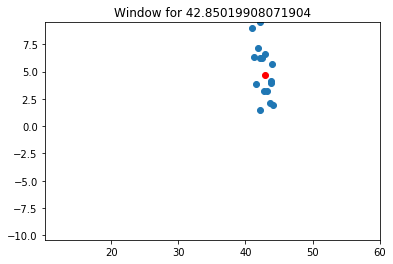

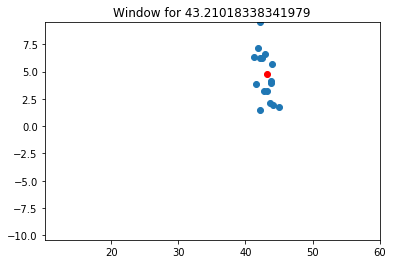

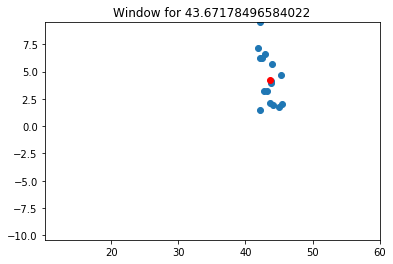

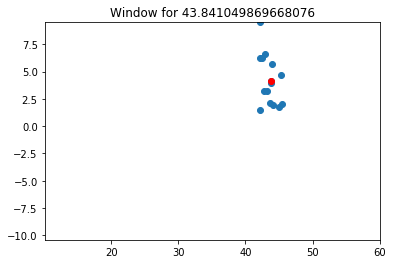

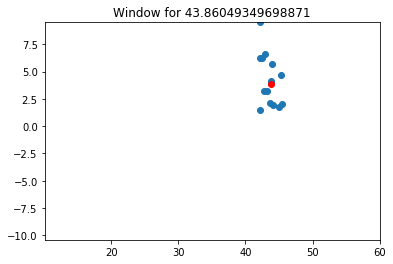

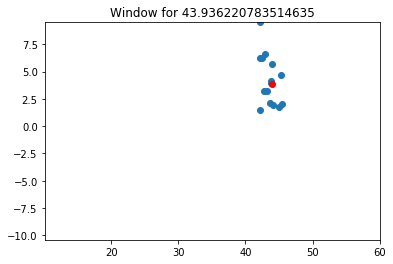

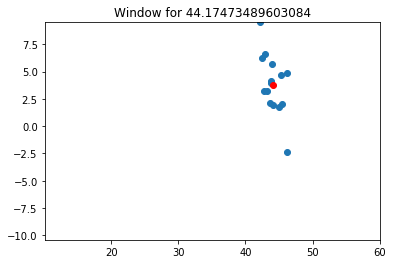

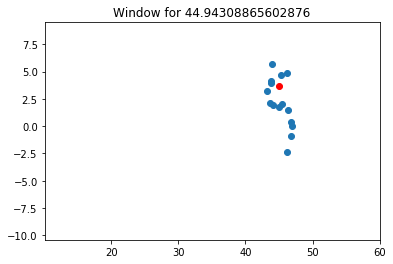

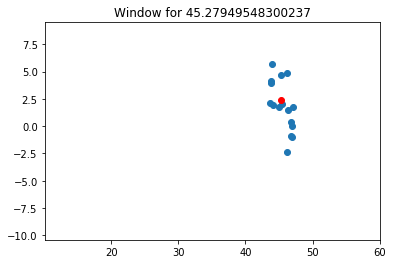

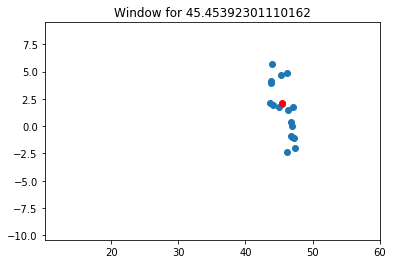

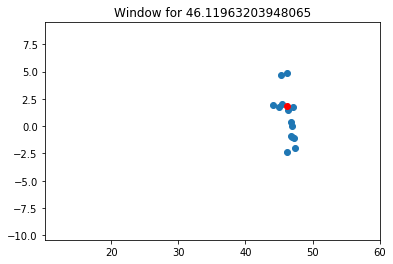

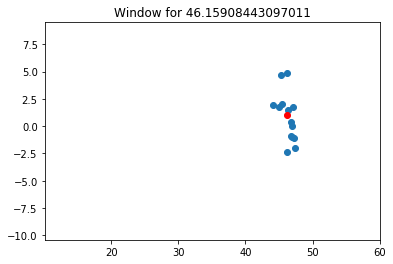

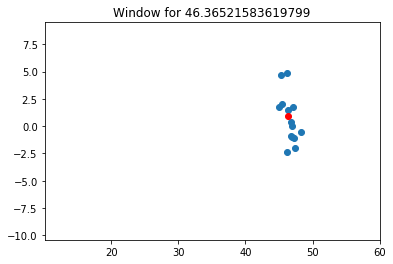

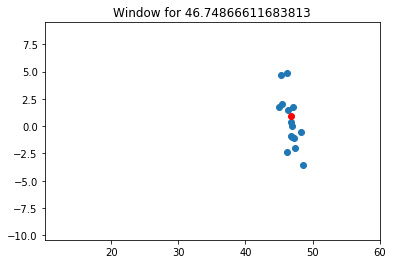

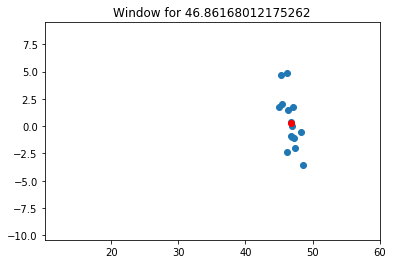

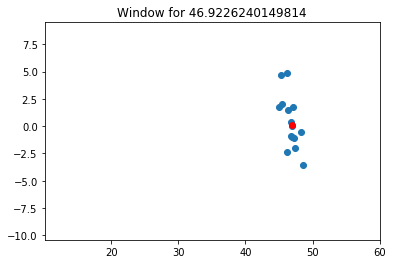

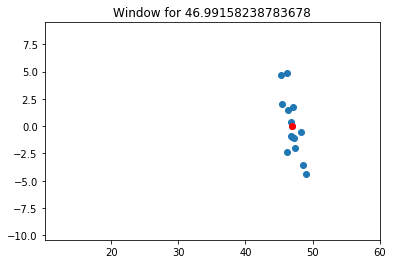

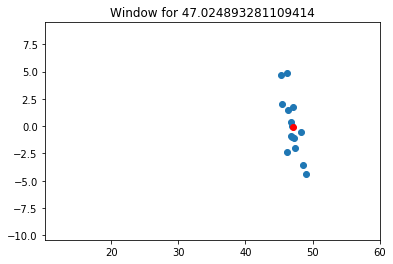

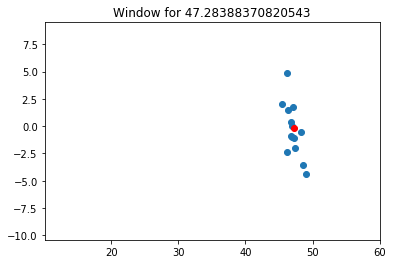

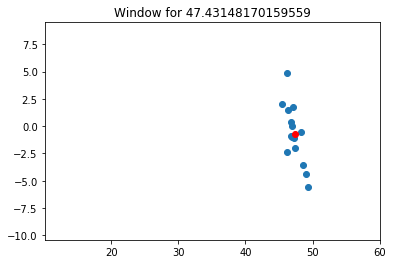

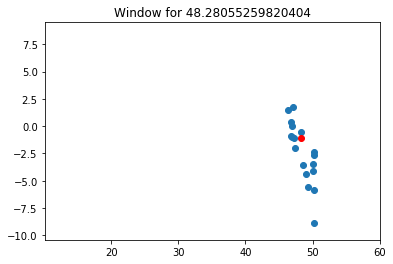

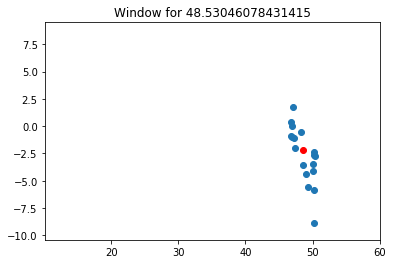

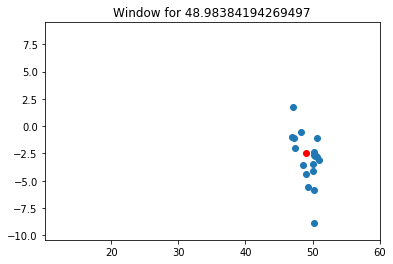

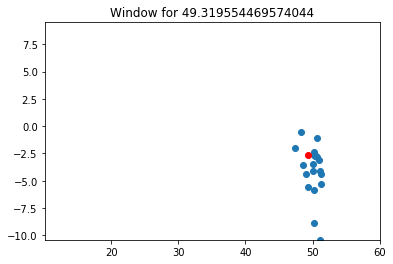

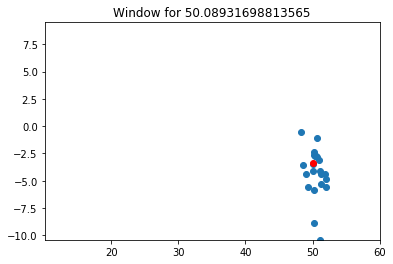

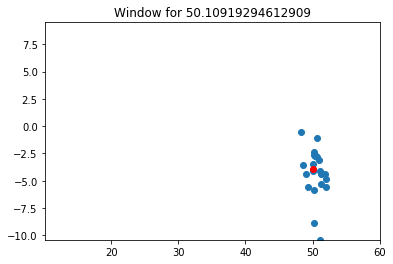

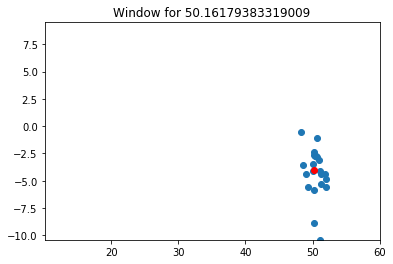

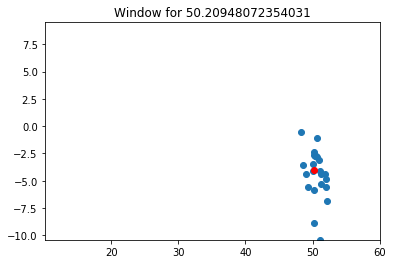

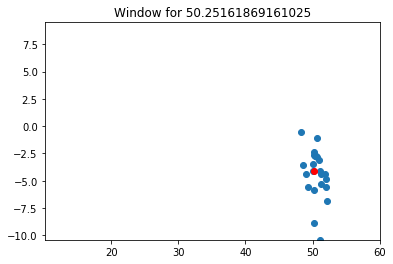

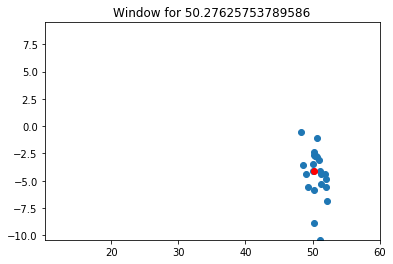

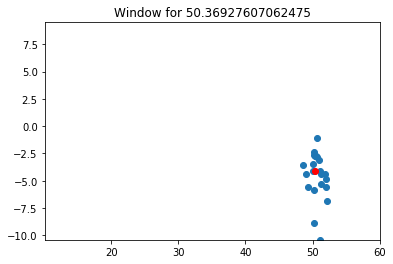

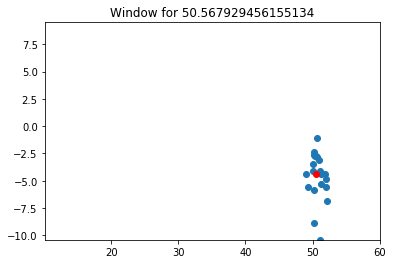

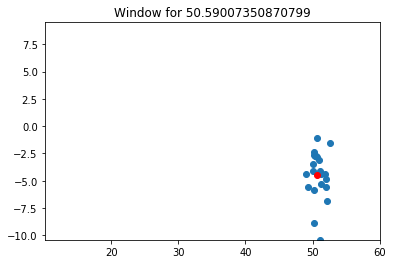

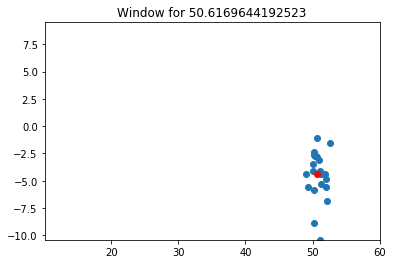

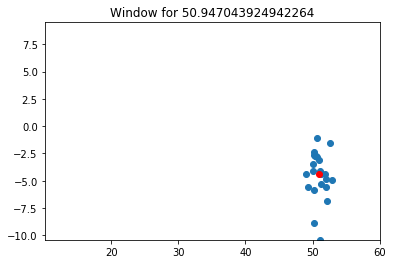

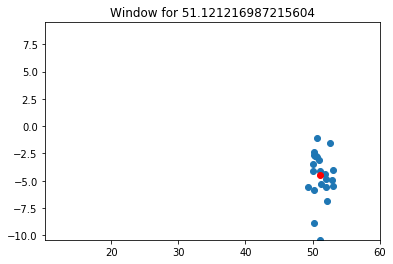

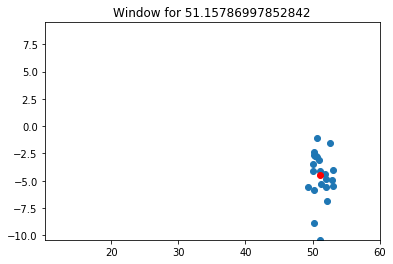

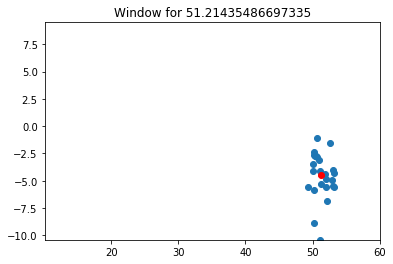

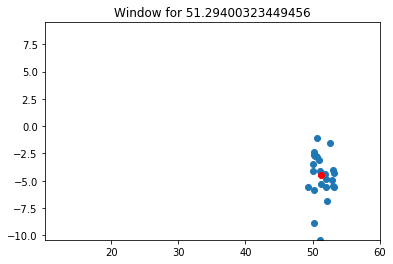

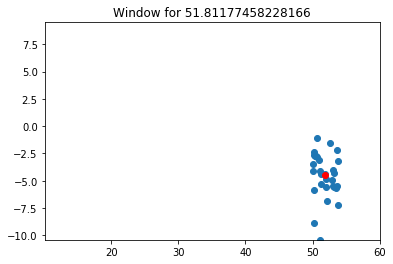

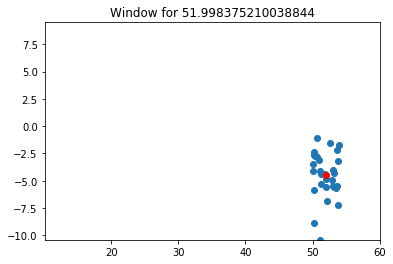

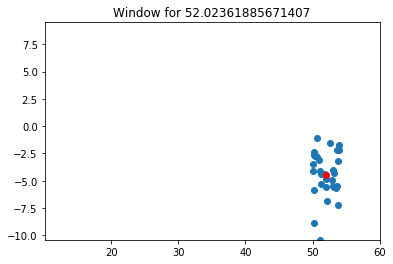

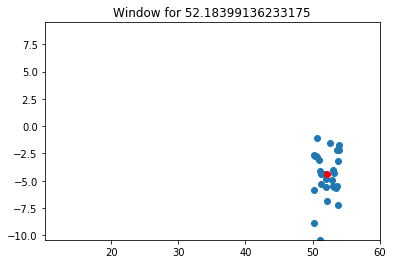

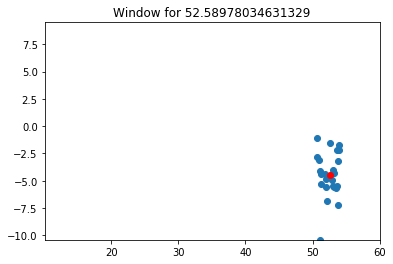

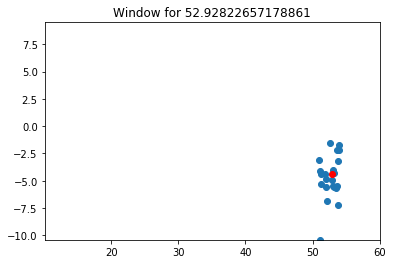

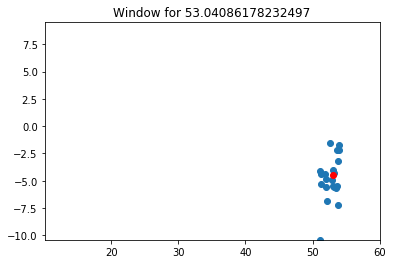

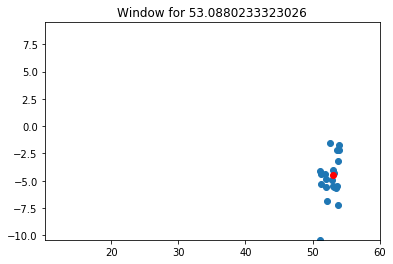

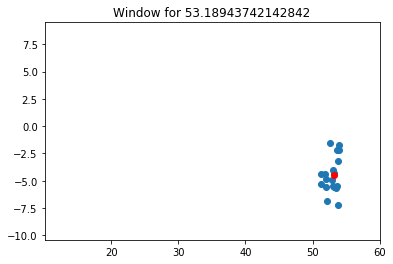

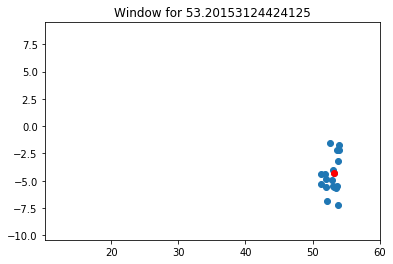

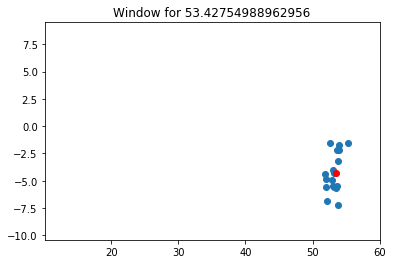

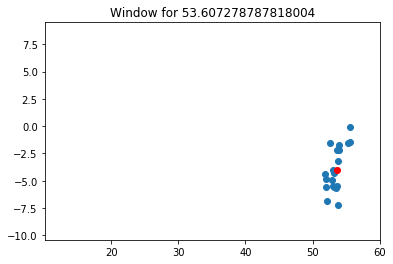

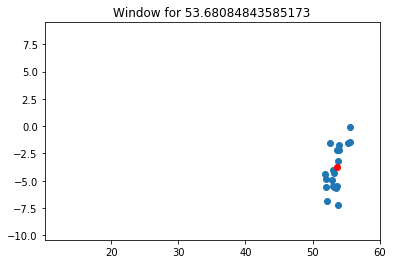

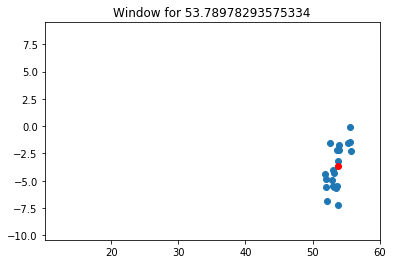

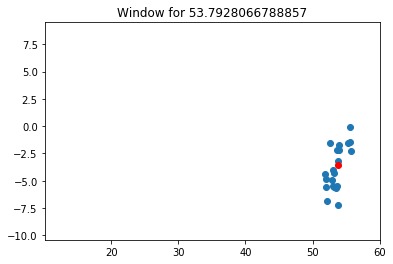

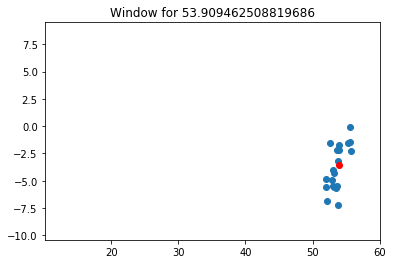

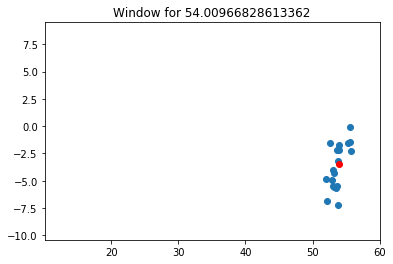

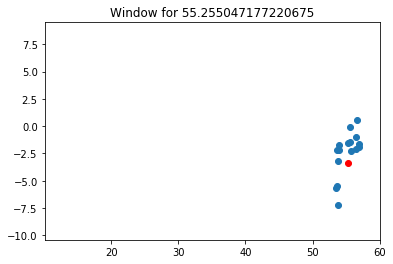

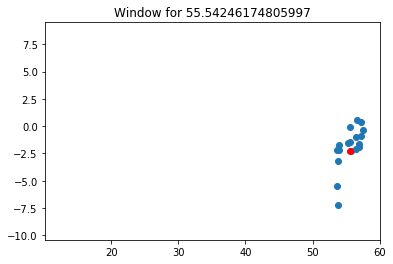

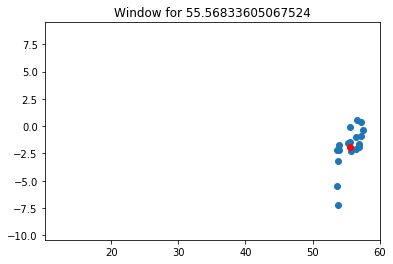

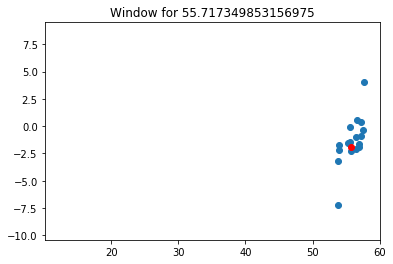

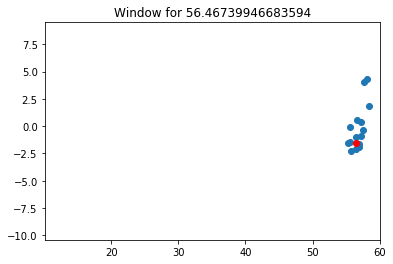

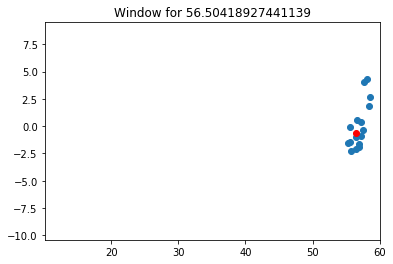

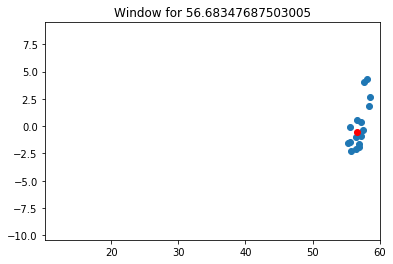

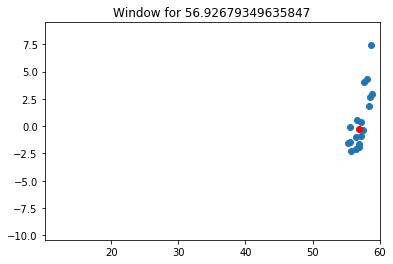

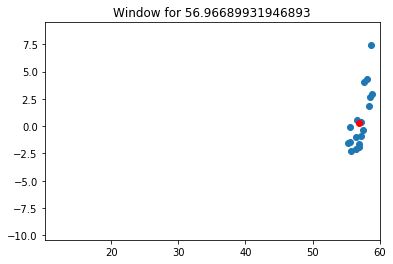

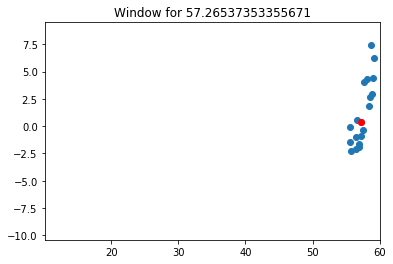

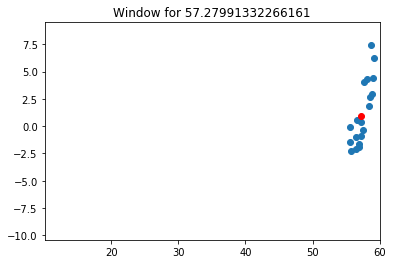

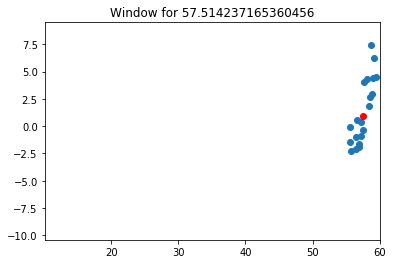

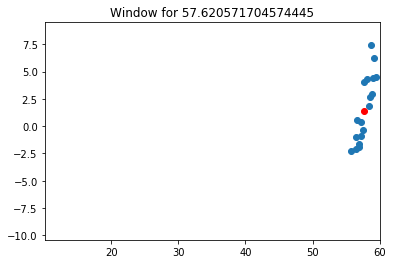

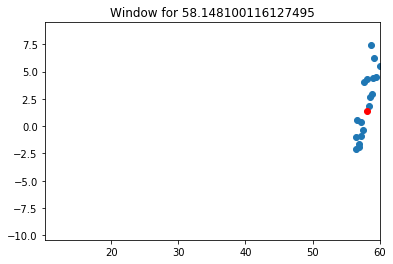

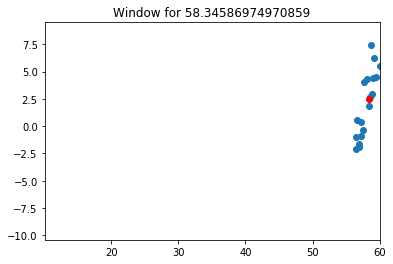

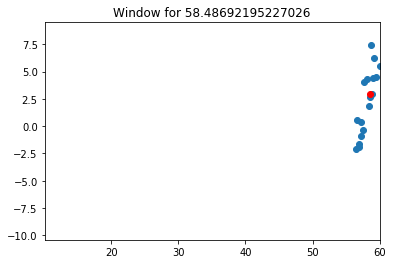

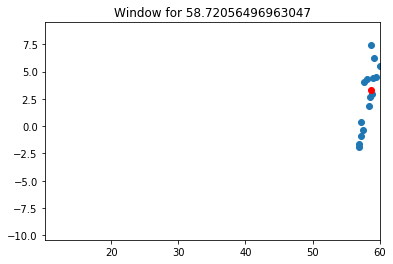

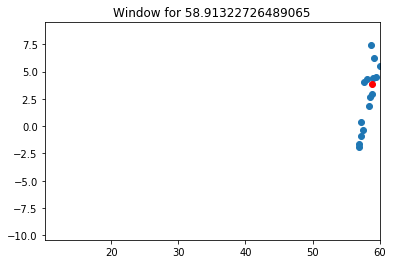

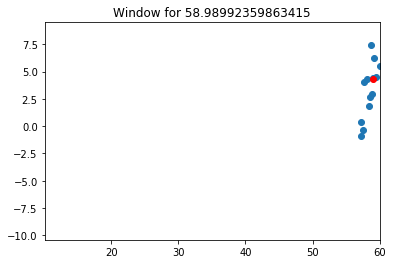

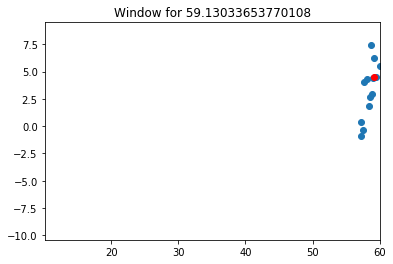

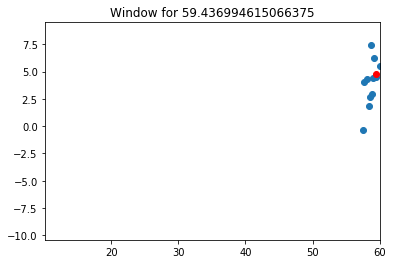

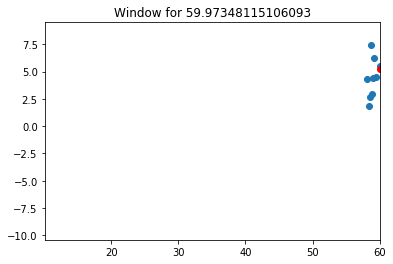

In [3]:
np.random.seed(0)
noise_std=2
x, y = generate_noisy_sine_data(noise_std)
model = LinearRegression()

smoother = LoessSmoother(model=None,
                         n_degree=1,
                         transform=True,
                         window_method='fixed',
                         window_size=2,
                         step_size=.2,
                         fraction=.1)

smoother.fit(x,y)


plot_windows(x,y, smoother.x_focal_base, smoother.y_focal_base, smoother.indices)


# Full plot

In [7]:
len(smoother.indices),len(smoother.x_focal_base), len(smoother.y_focal_base), len(smoother.model_per_window)

(200, 200, 201, 201)

In [8]:
smoother.y_focal_base

array([ 0.        , -1.09802606, -1.58687773, -1.63163283, -1.71299902,
       -2.35535364, -2.83478804, -2.91513895, -3.06163971, -3.38020373,
       -3.51628411, -3.55939649, -3.56776601, -3.66421101, -3.91617795,
       -4.10429946, -4.11477301, -4.2809386 , -4.45590654, -4.50186712,
       -4.6040631 , -4.66928146, -4.34029868, -4.37726206, -4.52696926,
       -4.50783143, -4.50356155, -4.50149665, -4.76717487, -4.72383555,
       -4.68356874, -4.67645016, -4.58895227, -4.34977291, -4.24612812,
       -3.90130242, -3.89263572, -3.89064861, -3.06403035, -2.88954944,
       -2.9556746 , -2.40452608, -1.57377984, -1.56025375, -1.28376514,
       -0.77550493, -0.75482743, -0.71705532, -0.17938376, -0.02568545,
        0.19689166,  0.25951902,  1.94896494,  1.98001185,  2.11986007,
        2.29109766,  2.44618511,  3.22850703,  3.18463229,  3.19173521,
        3.28411718,  3.35491999,  3.53233954,  3.46681208,  3.47507827,
        3.50386185,  3.51728667,  3.51996942,  3.51345069,  3.48

ValueError: x and y must be the same size

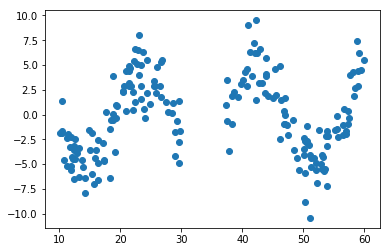

In [4]:
plt.scatter(x, y)
plt.scatter(smoother.x_focal_base,smoother.y_focal_base, c='r', marker='.')

# Tomi's code

In [ ]:
import math

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


# TODO: Include weights
class LoessSmoother:
    def __init__(self, p_degree=1, frac=0.3, point_extraction='knn', weights=None):

        self.frac = frac

        # Create a pipeline in case that the user wants to perform a polynomial degree fit:
        self.model = Pipeline([('p_features', PolynomialFeatures(degree=p_degree, include_bias=True)),
                               ('linear', LinearRegression())])

        self.point_extraction = point_extraction
        # This should be a function to calculate weights, e.g. Gaussian, Linear, etc...
        self.weights = weights

    def get_point_sets(self, X):
        if self.point_extraction == 'knn':
            knn = NearestNeighbors(n_neighbors=self.n_points, metric='euclidean').fit(X)

            # For every point return n nearest points:
            for idx, point in enumerate(X):
                yield knn.kneighbors(point.reshape(-1, 1))[1][0]

        elif self.point_extraction == 'symmetric':
            for idx, point in enumerate(X):
                if idx < math.floor(self.frac * len(X) / 2):
                    yield np.array(range(0, idx + math.floor(self.frac * len(X) / 2)))

                elif (idx >= math.floor(self.frac * len(X) / 2)) & (
                (idx <= len(X) - math.floor(self.frac * len(X) / 2))):
                    yield np.array(
                        range(idx - math.floor(self.frac * len(X) / 2), idx + math.floor(self.frac * len(X) / 2)))

                else:
                    yield np.array(range(len(X) - math.floor(self.frac * len(X) / 2), len(X)))

        else:
            raise NotImplementedError('Sorry this method has not been implemented.')

    def fit(self, X, y):

        if len(X.shape) < 2:
            X = X.reshape(-1, 1)

        points_generator = self.get_point_sets(X)
        self.y_focal = np.array([])

        for idx_focal, idx_window in enumerate(points_generator):
            x_focal = X[idx_focal].reshape(-1, 1)
            x_window = X[idx_window].reshape(-1, 1)
            y_window = y[idx_window]

            if self.weights == None:
                weights = np.ones(np.shape(x_window)[0])

            else:
                raise NotImplementedError('Weights can not be specified at this point.')

            y_focal_new = (self.model.fit(x_window,
                                          y_window,
                                          linear__sample_weight=weights)
                           .predict(x_focal.reshape(-1, 1)))

            self.y_focal = np.append(self.y_focal, y_focal_new)

        return self

    def transform(self, X):
        return self.y_focal


def random_x(minimum_val, maximum_val, size):
    """
    Generate n random data-points of size between minimum_val and right bounds
    :param minimum_val: float, minimal value of the generated data
    :param maximum_val: float, maximum value of the generated data
    :param size: tuple or list, shape of the desired output
    :return: np.Array with generated data
    """
    return (maximum_val - minimum_val) * np.random.random(size=size) + minimum_val


def generate_data(x, generate_function, noise_std):
    """
    Return f(x) with added normal distributed noise with standard deviation noise_std.
    :param x: np.Array, input data
    :param generate_function: function to apply to input data
    :param noise_std: non-negative float, standard deviation of added noise.
    :return: np.Array, y = f(x) + N(0, std)
    """
    return generate_function(x) + np.random.normal(loc=0, scale=noise_std, size=x.shape)
